<a href="https://colab.research.google.com/github/isaacchunn/cartpole-balancing/blob/main/cartpole_balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Balancing a Pole on a Cart
23S2 SC3000/CZ3005 Assignment 1

Team Members:

1. Isaac Chun Jun Heng U2221389B
2. J'sen Ong Jia Xuan U2220457J
3. Marcus Ho Jian Feng

### References

1. https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
    - Usage: To understand more about cartpole environment and how rewards are given.

2. https://www.youtube.com/watch?v=nOBm4aYEYR4&ab_channel=YannicKilcher
    - Usage: Understanding Q Learning fundamentals and how it works / updating q-tables

3. https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial
    - Usage: Practice Q Learning on Discrete environments such as Frozen Lake and help us setup the base for notebook on what to import and how to render videos and gifs


### Importing Libraries

In [16]:
#Gymnasium
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
from gym.error import DependencyNotInstalled
gymlogger.set_level(40) #error only
#I dont think we use tensorflow though
import tensorflow as tf
#Graph plotting stuff
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#Globals and os for file paths
import glob
import io
import os
import base64
import math
#Python displays
from IPython.display import HTML
from IPython import display as ipythondisplay
#Progress bars to visualize training
from tqdm.notebook import trange


In [82]:
#GPU accelerated notebooks to speed up the training of our agent in case I want to create custom environments and run in parallel
import torch
torch.cuda.is_available()

True

### Render Video Function
---

In [83]:
def show_video():
  '''
  Collects all videos in the /video subfolder and picks the first file in that list to open and display a video.
  '''
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

# Loading CartPole Environment
---

gym reference : https://www.gymlibrary.dev/environments/classic_control/cart_pole/

In [19]:
#Load our cartpole environment based on v1 version
env = gym.make("CartPole-v1")

The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [20]:
#Print our observation space
print("Observation Space", env.observation_space)
print("Sample Observation", env.observation_space.sample()) #Display a random observation

Observation Space Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Sample Observation [ 2.4263921e+00  4.2934418e+37 -2.5099844e-01  1.6049178e+38]


In [21]:
#Print action space
print("Action Space", env.action_space)
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample())

Action Space Discrete(2)
Action Space Shape 2
Action Space Sample 0


Our action space is discrete, its either we tell the thing to go left or go right, so our q table should have 2 columns, and for each possible state, it would be a A x B x C x ... x 2

### Initializing Q-Table
---



Since the space is continuous, we will split the observation space into a set amount of segments to be refined and tested. For each of the continuous variables in the observation space, we will split them into discrete sections.

| Num | Observation | Min | Max|
|--|--|--|--|
| 0 | Cart Position |-4.8| 4.8
| 1 | Cart Velocity |-Inf| Inf
| 2 | Pole Angle |~ -0.418 rad (-24°)| ~ 0.418 rad (24°)
| 3 | Pole Angular Velocity |-Inf| Inf

However, even if the observation space has their own min and maxes, the following is noted:

1. The cart x-position (index 0) can take values between (-4.8, 4.8), but the episode *terminates* if the cart leaves the (-2.4, 2.4) range.

2. The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode *terminates* if the pole angle is not in the range (-.2095, .2095) (or ±12°)

3. For cart velocity and cart angular velocity, there are inf, but we cant divide them infinite into discrete segments, so our range of -4 to 4 is the usual range that the cart goes by printing out the max and min velocity of the cart between episodes.

In [22]:
#Declare num of segments to split continuous space into
num_segments = 10

#Converted into a linear space of segments given our requirements
pos_space = np.linspace(-2.4, 2.4, num_segments)
vel_space = np.linspace(-4, 4, num_segments)
ang_space = np.linspace(-0.2095, 0.2095, num_segments)
angvel_space = np.linspace(-4, 4, num_segments)

def initialize_qtable(pos_space = pos_space, vel_space = vel_space, ang_space = ang_space, av_space = angvel_space, num_segments = num_segments):
    #Make our q table which is a 11 x 11 x 11 x 11 x 2 (a very large table that increases exponentially with more segments!) -> +1 due to np.digitize function
    Qtable = np.zeros((len(pos_space) + 1, len(vel_space) + 1, len(ang_space) + 1, len(angvel_space) + 1, env.action_space.n))
    return Qtable

#Make our q table which is a 11 x 11 x 11 x 11 x 2 (a very large table that increases exponentially with more segments!) -> +1 due to np.digitize function
q_table_cart = initialize_qtable()

In [23]:
q_table_cart.shape

(11, 11, 11, 11, 2)

### Initializing Hyperpameters
---


In [47]:
#Training parameters
learning_rate = 0.1
gamma = 0.99
num_episodes = 50000

#Exploration parameters
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay_rate = 0.0001

#Other training parameters
desired_mean_reward = 480

In [25]:
#Other parameters such as episodic steps to print out progress
episode_steps = 250

### Declare an epsilon greedy policy
---

In [26]:
#Epsilon greedy policy (acting policy)
#In this case, state is a tuple that is passed in where state holds the following information at this time
# state[0] = cart position
# state[1] = cart velocity
# state[2] = cart angle
# state[3] = cart ang velocity
def epsilon_greedy_policy(q_table, state, epsilon):
    #Random some number
    random_d = np.random.random()
    #If its above epsilon, then the action is the optimal given this current state with the highest q value
    if(random_d > epsilon):
        action = np.argmax(q_table[state[0], state[1], state[2], state[3], :])
    else:
        #Else the action is random to allow exploration
        action = env.action_space.sample()
    return action

## Task 1 - Training the Agent
---

For training, we will attempt two different strategies to train our agent.

1. Episodic Default Training (user defined episode)
2. Training till Desired Mean (user defined target mean)

For our epsilon decay formula, we will use epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate * episode), and exponential curve such it never goes past min epsilon and allows smooth decay for intiial rapid decline and slow as epsilon reaches minimal value for still chances at exploration


### 1. Episodic Default Training of Agent

This approach uses a set amount of episodes based on hyperparameters and trains the agent using epsilon greedy policy and simple updating of the policies. The rewards are used as is to update the qtable

In [40]:
#Store an array of zeros for the rewards per episode to keep track for plotting later on
reward_per_episode = []
def train_agent_default(env, num_episodes, learning_rate, gamma, max_epsilon, epsilon_decay_rate, q_table):
  total_reward = 0
  #Initialize epsilon to the max
  #epsilon = max_epsilon
  for episode in trange(num_episodes):
    #Calculate the new epsilon using a formula that decreases exponentially through episodes
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate * episode)   
    #Reset the environment
    state = env.reset()
    #Digitize and get the state data
    state_pos = np.digitize(state[0], pos_space)
    state_vel = np.digitize(state[1], vel_space)
    state_ang = np.digitize(state[2], ang_space)
    state_angVel = np.digitize(state[3], angvel_space)
  
    done = False
    episode_reward = 0

    #Run till all the episodes are complete
    while not done:
      #Determine our policy based on epsilon greedy
      action = epsilon_greedy_policy(q_table, (state_pos, state_vel, state_ang, state_angVel), epsilon)

      #Take the chosen action and observe the new state
      new_state, reward, done, info = env.step(action)
      #Update on the new state stuff
      new_state_pos = np.digitize(new_state[0], pos_space)
      new_state_vel = np.digitize(new_state[1], vel_space)
      new_state_ang = np.digitize(new_state[2], ang_space)
      new_state_angVel = np.digitize(new_state[3], angvel_space)
      
      #Update our q table based on the formula
      q_table[state_pos, state_vel, state_ang, state_angVel, action] = q_table[state_pos, state_vel, state_ang, state_angVel, action] + learning_rate * (reward + gamma * np.max(q_table[new_state_pos, new_state_vel, new_state_ang, new_state_angVel, :]) -  q_table[state_pos, state_vel, state_ang, state_angVel, action])
      
      #update the current state to the new state
      state = new_state
      state_pos = new_state_pos
      state_vel = new_state_vel
      state_ang = new_state_ang
      state_angVel = new_state_angVel
      #Update our rewards for this episode
      episode_reward += reward
    
    #Update our rewards per episode array
    reward_per_episode.append(episode_reward)
    #Update total reward
    total_reward += episode_reward
    #Print out progress every X episodes
    mean_rewards = np.mean(reward_per_episode[len(reward_per_episode)-episode_steps:])
    #Print out the results every "episode_steps" -> default value 100
    if episode % episode_steps == 0:
      print(f'Episode: {episode} Episode Reward: {episode_reward}  Epsilon: {epsilon:0.2f}  Mean Rewards for past {episode_steps} episodes : {mean_rewards:0.1f}')
    
    #Decreate epsilon by decay rate
    #epsilon = max(epsilon - epsilon_decay_rate, 0)
  env.close()
  return q_table

In [53]:
#Train the table
#initialize q_table cart
q_table_cart = initialize_qtable()
q_table_cart = train_agent_default(env, num_episodes, learning_rate, gamma, max_epsilon, epsilon_decay_rate, q_table_cart)

  0%|          | 0/50000 [00:00<?, ?it/s]

Episode: 0 Episode Reward: 25.0  Epsilon: 1.00  Mean Rewards for past 250 episodes : 297.9
Episode: 250 Episode Reward: 36.0  Epsilon: 0.98  Mean Rewards for past 250 episodes : 23.0
Episode: 500 Episode Reward: 26.0  Epsilon: 0.95  Mean Rewards for past 250 episodes : 23.9
Episode: 750 Episode Reward: 44.0  Epsilon: 0.93  Mean Rewards for past 250 episodes : 22.5
Episode: 1000 Episode Reward: 33.0  Epsilon: 0.91  Mean Rewards for past 250 episodes : 24.9
Episode: 1250 Episode Reward: 47.0  Epsilon: 0.88  Mean Rewards for past 250 episodes : 26.1
Episode: 1500 Episode Reward: 17.0  Epsilon: 0.86  Mean Rewards for past 250 episodes : 26.7
Episode: 1750 Episode Reward: 43.0  Epsilon: 0.84  Mean Rewards for past 250 episodes : 28.0
Episode: 2000 Episode Reward: 69.0  Epsilon: 0.82  Mean Rewards for past 250 episodes : 30.8
Episode: 2250 Episode Reward: 48.0  Epsilon: 0.80  Mean Rewards for past 250 episodes : 31.2
Episode: 2500 Episode Reward: 23.0  Epsilon: 0.78  Mean Rewards for past 25

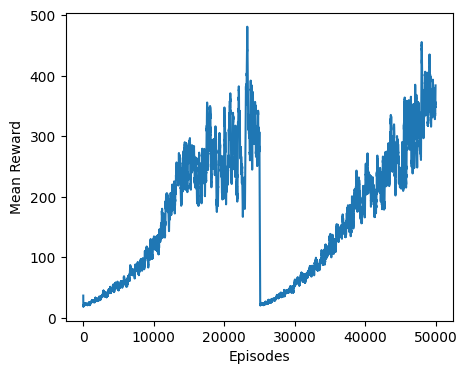

In [55]:
mean_rewards = []
for t in range(num_episodes):
    mean_rewards.append(np.mean(reward_per_episode[max(0, t-100):(t+1)]))

plt.figure(figsize = (5,4))
plt.xlabel("Episodes")
plt.ylabel("Mean Reward")
plt.plot(mean_rewards)

### 2. Training of Agent till Desired Mean Reward

This approach trains the agent until the mean rewards has hit the amount defined in the hyperparameters, and also serves as a guide to approximate how many episodes are needed to achieve a mean reward to help finetune our hyperparameters

In [30]:
#Setup some parameters for this type of training
reward_per_episode_mean = []
def train_agent_to_desired_mean(env, learning_rate, gamma, max_epsilon, epsilon_decay_rate, q_table):
  #Starting from episode 1
  episode = 0
  while True: 
    #Calculate the new epsilon using a formula that decreases exponentially through episodes
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate * episode)   
    #Reset the environment
    state = env.reset()
    #Digitize and get the state data
    state_pos = np.digitize(state[0], pos_space)
    state_vel = np.digitize(state[1], vel_space)
    state_ang = np.digitize(state[2], ang_space)
    state_angVel = np.digitize(state[3], angvel_space)
  
    done = False
    episode_reward = 0

    #Run till we have hit our desired episode rewards
    while not done:
      #Determine our policy based on epsilon greedy
      action = epsilon_greedy_policy(q_table, (state_pos, state_vel, state_ang, state_angVel), epsilon)

      #Take the chosen action and observe the new state
      new_state, reward, done, info = env.step(action)
      #Update on the new state stuff
      new_state_pos = np.digitize(new_state[0], pos_space)
      new_state_vel = np.digitize(new_state[1], vel_space)
      new_state_ang = np.digitize(new_state[2], ang_space)
      new_state_angVel = np.digitize(new_state[3], angvel_space)

      #Update our qtable based on this state
      q_table[state_pos, state_vel, state_ang, state_angVel, action] = q_table[state_pos, state_vel, state_ang, state_angVel, action] + learning_rate * (reward + gamma * np.max(q_table[new_state_pos, new_state_vel, new_state_ang, new_state_angVel, :]) -  q_table[state_pos, state_vel, state_ang, state_angVel, action])
      
      #update the current state to the new state
      state = new_state
      state_pos = new_state_pos
      state_vel = new_state_vel
      state_ang = new_state_ang
      state_angVel = new_state_angVel
      
      #Update our rewards for this episode
      episode_reward += reward
    
    #Append this reward into the episode dynamic list
    reward_per_episode_mean.append(episode_reward)
    #Calculate the mean rewards for the past 100 episodes
    mean_rewards = np.mean(reward_per_episode_mean[len(reward_per_episode_mean)-episode_steps:])
    #Print out the results every "episode_steps" -> default value 100
    if episode % episode_steps == 0:
      print(f'Episode: {episode} Episode Reward: {episode_reward}  Epsilon: {epsilon:0.2f}  Mean Rewards for past {episode_steps} episodes : {mean_rewards:0.1f}')
    
    #Break if we have reached our desired mean (set in hyper parameters)
    if mean_rewards >= desired_mean_reward:
      print(f'Finished at Episode: {episode} Episode Reward: {episode_reward}  Epsilon: {epsilon:0.2f}  Mean Rewards for past {episode_steps} episodes : {mean_rewards:0.1f}')
      break

    #Increment our episode
    episode += 1
  env.close()
  return q_table


In [31]:
#Train the table
#initialize q_table cart
q_table_cart_mean = initialize_qtable()
q_table_cart_mean = train_agent_to_desired_mean(env, learning_rate, gamma, max_epsilon, epsilon_decay_rate, q_table_cart)

Episode: 0 Episode Reward: 19.0  Epsilon: 1.00  Mean Rewards for past 250 episodes : 19.0
Episode: 250 Episode Reward: 16.0  Epsilon: 0.98  Mean Rewards for past 250 episodes : 23.2
Episode: 500 Episode Reward: 18.0  Epsilon: 0.95  Mean Rewards for past 250 episodes : 23.9
Episode: 750 Episode Reward: 27.0  Epsilon: 0.93  Mean Rewards for past 250 episodes : 26.3
Episode: 1000 Episode Reward: 14.0  Epsilon: 0.91  Mean Rewards for past 250 episodes : 26.4
Episode: 1250 Episode Reward: 28.0  Epsilon: 0.88  Mean Rewards for past 250 episodes : 25.8
Episode: 1500 Episode Reward: 52.0  Epsilon: 0.86  Mean Rewards for past 250 episodes : 27.8
Episode: 1750 Episode Reward: 42.0  Epsilon: 0.84  Mean Rewards for past 250 episodes : 29.0
Episode: 2000 Episode Reward: 45.0  Epsilon: 0.82  Mean Rewards for past 250 episodes : 32.5
Episode: 2250 Episode Reward: 36.0  Epsilon: 0.80  Mean Rewards for past 250 episodes : 32.0
Episode: 2500 Episode Reward: 72.0  Epsilon: 0.78  Mean Rewards for past 250

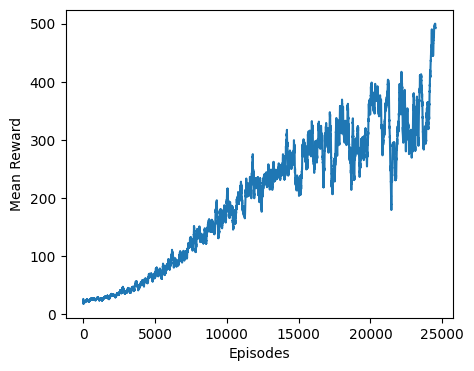

In [48]:
mean_rewards = []
for t in range(len(reward_per_episode_mean)):
    mean_rewards.append(np.mean(reward_per_episode_mean[max(0, t-100):(t+1)]))
plt.figure(figsize = (5,4))
plt.xlabel("Episodes")
plt.ylabel("Mean Reward")
plt.plot(mean_rewards)

### Answer for Task 1 : Sampling random state and outputting chosen action
---

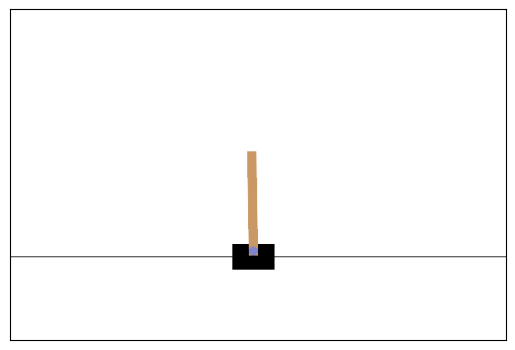

Observation:  [-0.04204608 -0.00924733 -0.01830408  0.02997212]
Chosen action:  0


In [80]:
#Remake our environment
env = gym.make("CartPole-v1")
#Reset the environment and get our initial state
state = env.reset()

#Render the current state 
img = env.render(mode="rgb_array")
#Hide the ticks
plt.xticks([])  # Set label locations.
plt.yticks([])
plt.imshow(img)
plt.show()
#
#Print out the state
print("Observation: ", state)
#Get the discrete values from the state
state_pos = np.digitize(state[0], pos_space)
state_vel = np.digitize(state[1], vel_space)
state_ang = np.digitize(state[2], ang_space)
state_angVel = np.digitize(state[3], angvel_space)

#Get the action using our q_table calculated
action = np.argmax(q_table_cart_mean[state_pos, state_vel, state_ang, state_angVel, :])

#Print chosen action
print("Chosen action: ", action)

From the above diagram, the cartpole is slightly bent towards the left, which means the cartpole should move left to balance it, which means our agent is correct in this decision.

## Task 2 - Effectiveness of Agent
---

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

**Episode End**
1. The episode ends if any one of the following occurs:
2. Termination: Pole Angle is greater than ±12°
3. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
4. Truncation: Episode length is greater than 500.


In [94]:
#Store the rewards stored in each episode
def evaluate_agent(env, q_table, n_eval_episodes = 100):
  episode_rewards = np.zeros(100)
  for episode in trange(n_eval_episodes):
    #Reset the environment
    state = env.reset()
    
    #Get each discrete variable
    state_pos = np.digitize(state[0], pos_space)
    state_vel = np.digitize(state[1], vel_space)
    state_ang = np.digitize(state[2], ang_space)
    state_angVel = np.digitize(state[3], angvel_space)

    done = False
    #Store the reward in each episode
    episode_reward = 0
    
    #Run each episode until it ends using our agent
    while not done:
      #Use our previously calculated q_table to always choose the best action instead of our greedy epsilon for training
      action = np.argmax(q_table[state_pos, state_vel, state_ang, state_angVel])
      
      #Take the chosen action and observe the new state
      new_state, reward, done, info = env.step(action)
      #Update on the new state stuff
      new_state_pos = np.digitize(new_state[0], pos_space)
      new_state_vel = np.digitize(new_state[1], vel_space)
      new_state_ang = np.digitize(new_state[2], ang_space)
      new_state_angVel = np.digitize(new_state[3], angvel_space)
      
      #Add the reward into our current episode reward
      episode_reward += reward
      
      #Then update our states and previous states
      state = new_state
      state_pos = new_state_pos
      state_vel = new_state_vel
      state_ang = new_state_ang
      state_angVel = new_state_angVel
    
  
    #Append the reward gotten in this episode into our total reward arrays
    episode_rewards[episode] = (episode_reward)

  #Calculate the mean and std of our episode rewards array
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)
  env.close()
  return episode_rewards, mean_reward, std_reward


In [95]:
episode_rewards, mean_reward, std_reward = evaluate_agent(env, q_table_cart_mean)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean_reward=500.00 +/- 0.00


In [97]:
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")


Mean_reward=500.00 +/- 0.00


Average cumulative reward: 500.0



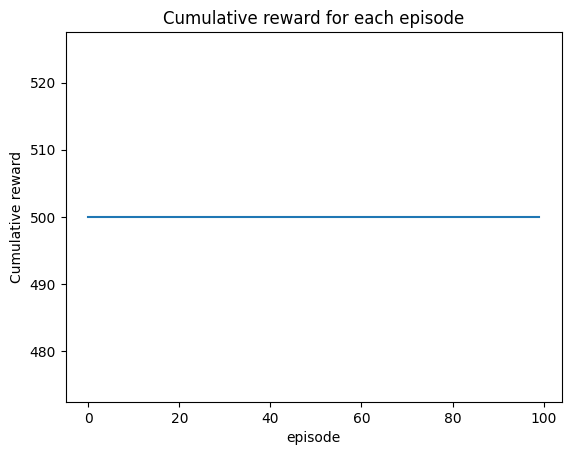

In [96]:
print("Average cumulative reward:", episode_rewards.mean())
print("")
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.plot(episode_rewards)
plt.show()


## Task 3 - Render one episode played by the agent
---



In [98]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
state = env.reset()
state_pos = np.digitize(state[0], pos_space)
state_vel = np.digitize(state[1], vel_space)
state_ang = np.digitize(state[2], ang_space)
state_angVel = np.digitize(state[3], angvel_space)

while True:
    env.render()
    #your agent goes here
    action = np.argmax(q_table_cart[state_pos, state_vel, state_ang, state_angVel, :])
    new_state, reward, done, info = env.step(action)
    new_state_pos = np.digitize(new_state[0], pos_space)
    new_state_vel = np.digitize(new_state[1], vel_space)
    new_state_ang = np.digitize(new_state[2], ang_space)
    new_state_angVel = np.digitize(new_state[3], angvel_space)
    if done:
      break
      
    #update the current state to the new state
    state = new_state
    state_pos = new_state_pos
    state_vel = new_state_vel
    state_ang = new_state_ang
    state_angVel = new_state_angVel
env.close()
show_video()


C:\Users\isaac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
